# Time Delay Accuracy and Precision

_Phil Marshall & Lynne Jones_

In the first [Time Delay Challenge](http://timedelaychallenge.org) paper, [Liao et al (2015)](http://arxiv.org/pdf/1409.1254.pdf) derived the following simple model for how strongly gravitationally lensed quasar time delay accuracy (A), precision (P) and success rate (f) depend on the night-to-night cadence, season and campaign length. 
wrote several metrics and stackers to determine time delay accuracy (A), precision (P) and success rate (f). 

\begin{align}
|A|_{\rm model} &\approx 0.06\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{0.0}
                          \left(\frac{\rm sea}  {\rm 4 months}\right)^{-1.0}
                          \left(\frac{\rm camp}{\rm 5 years} \right)^{-1.1} \notag \\
  P_{\rm model} &\approx 4.0\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{ 0.7}
                         \left(\frac{\rm sea}  {\rm 4 months}\right)^{-0.3}
                         \left(\frac{\rm camp}{\rm 5 years} \right)^{-0.6} \notag \\
  f_{\rm model} &\approx 30\% \left(\frac{\rm cad} {\rm 3 days}  \right)^{-0.4}
                        \left(\frac{\rm sea}  {\rm 4 months}\right)^{ 0.8}
                        \left(\frac{\rm camp}{\rm 5 years} \right)^{-0.2} \notag
\end{align}

The first two of these metrics are candidate Figure of Merit proxies, while one can imagine combining all three somehow to provide an approximate dark energy parameter Figuer of Merit. These three metrics are implemented in [`tdcMetric.py`](http://github.com/LSST-nonproject/sims_maf_contrib/tree/master/mafContrib/tdcMetric.py) of the  [sims_maf_contrib](http://github.com/LSST-nonproject/sims_maf_contrib) git repository. 

This notebook provides a demo calculation of these metrics, using the MAF python interface (requires sims_maf version >= 1.0). 

## Getting Started

You'll need the `sims_maf_contrib` folder on your `PYTHONPATH`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# Import MAF modules.
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metricBundles import MetricBundle, MetricBundleGroup
# Import the contributed metrics and stackers 
import mafContrib

## Setting up  the MAF Evaluation of the Baseline Cadence 

As usual, we need to set up a `MetricBundleGroup` object so that we can run all of the metrics it contains on a single `OpSim` output database, which we first have to connect to.

In [2]:
runName = 'minion_1016'
database = runName + '_sqlite.db'
opsdb = db.OpsimDatabase(database)
outDir = 'tmp'

Instantiate the metrics, stackers and slicer that we want to use. These are the TDC metrics, the season stacker, and the healpix slicer. Actually, since we'll just use the stackers in their default configuration, we don't need to explicitly instantiate the stackers -- MAF will handle that for us.  
Note that our metric (`TdcMetric`) is actually a "complex" metric, as it calculates A, P, and f in one go (thus re-using the cadence/season/campaign values which must also be calculated for each set of visits), and then has 'reduce' methods that separate each of these individual results into separate values. 

In [3]:
metric = mafContrib.TdcMetric(metricName='TDC', seasonCol='season', expMJDCol='expMJD', nightCol='night')
slicer = slicers.HealpixSlicer(nside=64, lonCol='ditheredRA', latCol='ditheredDec')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Let's set the plotFuncs so that we only create the skymap and histogram for each metric result. This is an optional step - otherwise, we'd just make the angular power spectra plots too. 

In [4]:
plotFuncs = [plots.HealpixSkyMap, plots.HealpixHistogram]
slicer.plotFuncs = plotFuncs

The last ingredient we need is an SQL query to define the subset of visits we are interested in. Let's do something quick, like just the _i_ band in the first three years.

In [5]:
sqlconstraint = 'night < %i and filter = "i"' % (3*365.25)
tdcBundle = MetricBundle(metric=metric, slicer=slicer, sqlconstraint=sqlconstraint, runName=runName)

/Users/pjm/miniconda2/envs/lsst/opt/lsst/sims_maf/python/lsst/sims/maf/metricBundles/metricBundle.py:62: UserWarning: Future warning - "sqlconstraint" will be deprecated in favor of "constraint" in a future release.
  warnings.warn('Future warning - "sqlconstraint" will be deprecated in favor of '


In [10]:
resultsDb = db.ResultsDb(outDir=outDir)
bdict = {'tdc':tdcBundle}
bgroup = MetricBundleGroup(bdict, opsdb, outDir=outDir, resultsDb=resultsDb)

## Running the Metrics and Working with the Results

We can query the database, run the stackers, run the metric calculation, and run the reduce functions with `runAll`. This would also generate summary statistics if we had defined any.

In [11]:
bgroup.runAll()

Querying database with constraint night < 1095 and filter = "i"
Found 152510 visits
Running:  ['tdc']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Note that we now have more bundles in our bundle dictionary. These new bundles contain the results of the reduce functions - so, the metrics A, P, f separately as well as the "cadence", "season" and "campaign" diagnostics. 

In [12]:
bdict.keys()

['TDC_Rate',
 'TDC_Accuracy',
 'TDC_Cadence',
 'TDC_Precision',
 'tdc',
 'TDC_Campaign',
 'TDC_Season']

We want to set the `plotDict` for each of these separately, so that we can get each plot to look "just right", and then we'll make the plots.

In [13]:
minVal = 0.01
maxVal = {'Accuracy':0.20, 'Precision':10.0, 'Rate':40, 'Cadence':14, 'Season':8.0, 'Campaign':11.0}
units = {'Accuracy':'%', 'Precision':'%', 'Rate':'%', 'Cadence':'days', 'Season':'months', 'Campaign':'years'}
for key in maxVal:
    plotDict = {'xMin':minVal, 'xMax':maxVal[key], 'colorMin':minVal, 'colorMax':maxVal[key]}
    plotDict['xlabel'] = 'TDC %s (%s)' % (key, units[key])
    bdict['TDC_%s' % (key)].setPlotDict(plotDict)

Plotting figures with night < 1095 and filter = "i" constraint now.


/Users/pjm/miniconda2/envs/lsst/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 261 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/pjm/miniconda2/envs/lsst/opt/lsst/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:487: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/Users/pjm/miniconda2/envs/lsst/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 38661 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/pjm/miniconda2/envs/lsst/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/pjm/miniconda2/envs/lsst/opt/lsst

Plotting complete.


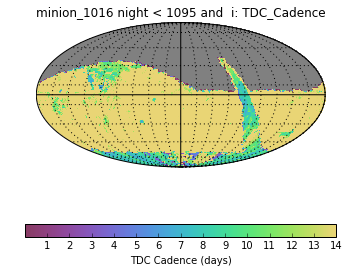

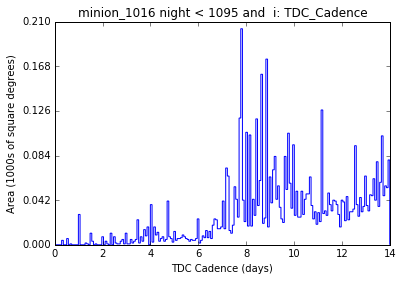

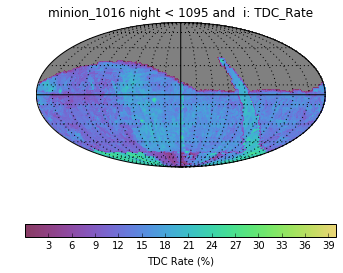

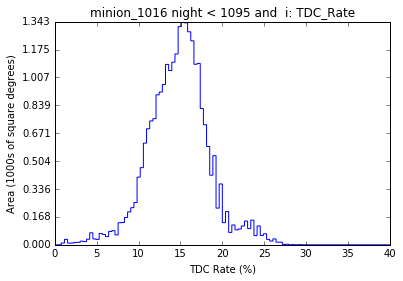

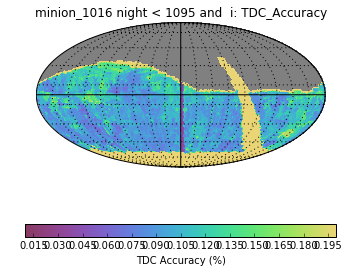

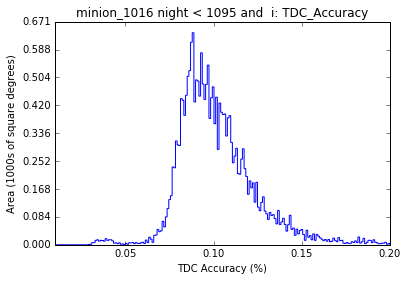

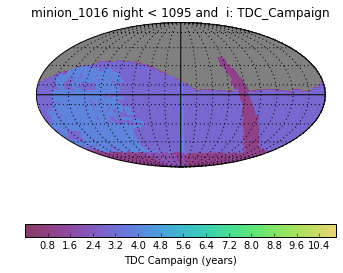

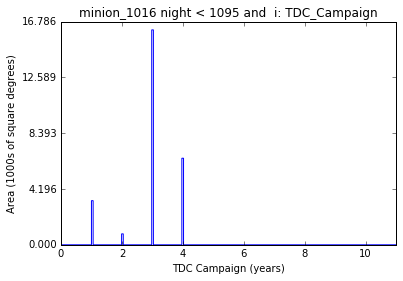

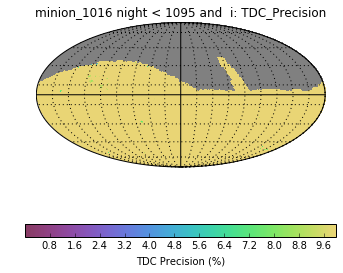

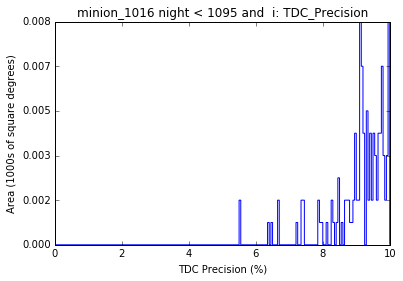

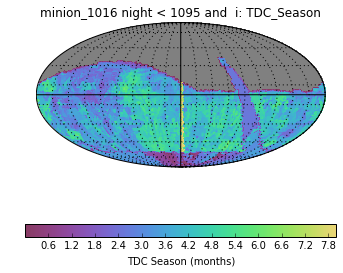

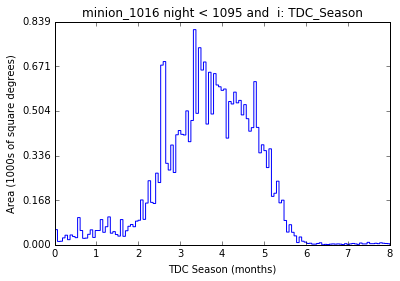

In [14]:
bgroup.plotAll(closefigs=False)

The `tdcBundle.metricValues` array contains the `HEALPix` maps of each metric.

In [15]:
tdcBundle.metricValues

masked_array(data = [-- -- -- ...,
 {'campaign': 2, 'season': 2.1188447342467116, 'precision': 16.150663928650395, 'rate': 14.904743205809638, 'cadence': 7.6500000000000004, 'accuracy': 0.3103459754284027}
 {'campaign': 2, 'season': 2.0203379506850854, 'precision': 16.485055462730656, 'rate': 14.296936251890907, 'cadence': 7.7181818181818187, 'accuracy': 0.32547769327807274}
 {'campaign': 2, 'season': 2.2665164383561649, 'precision': 16.898375404054544, 'rate': 15.152529891709843, 'cadence': 8.4000000000000004, 'accuracy': 0.2901258180629166}],
             mask = [ True  True  True ..., False False False],
       fill_value = -1.6375e+30)

Let's do some post-processing to turn the metric maps into single numbers for a table in the observing strategy white paper.

In [16]:
import numpy as np
x = tdcBundle.metricValues
index = np.where(x.mask == False)

In [17]:
f = np.array([each['rate'] for each in x[index]])
A = np.array([each['accuracy'] for each in x[index]])
P = np.array([each['precision'] for each in x[index]])
c = np.array([each['cadence'] for each in x[index]])
s = np.array([each['season'] for each in x[index]])
y = np.array([each['campaign'] for each in x[index]])
print np.mean(f), np.mean(A), np.mean(P), np.mean(c), np.mean(s), np.mean(y)

14.7041881924 0.854343983208 22.8794582534 21.0250411671 3.66777181025 2.96460426251


We are only interested in lenses with high accuracy delays, i.e. the fraction of the survey area where the _A_ metric is below some threshold. We can turn this into a sky area if we know the average size of a `HEALPix` pixel.

In [18]:
accuracy_threshold = 0.04 # 5 times better than threshold of 0.2% set by Hojjati & Linder (2014).

high_accuracy = np.where(A < accuracy_threshold)
high_fraction = 100*(1.0*len(A[high_accuracy]))/(1.0*len(A))
print "Fraction of total survey area providing high accuracy time delays = ",np.round(high_fraction,1),'%'

high_accuracy_cadence = np.median(c[high_accuracy])
print "Median night-to-night cadence in high accuracy regions = ",np.round(high_accuracy_cadence,1),'days'

high_accuracy_season = np.median(s[high_accuracy])
print "Median season length in high accuracy regions = ",np.round(high_accuracy_season,1),'months'

high_accuracy_campaign = np.median(y[high_accuracy])
print "Median campaign length in high accuracy regions = ",int(high_accuracy_campaign),'years'

Fraction of total survey area providing high accuracy time delays =  0.4 %
Median night-to-night cadence in high accuracy regions =  43.1 days
Median season length in high accuracy regions =  8.7 months
Median campaign length in high accuracy regions =  4 years


In [19]:
Nside = 64
Npix = 12*Nside**2
Area_per_pixel = 4*np.pi / float(Npix) # steradians
Area_per_pixel *= (180.0/np.pi)*(180.0/np.pi) # square degrees
high_accuracy_area = len(A[high_accuracy])*Area_per_pixel
print "Area of sky providing high accuracy time delays = ",int(high_accuracy_area),"sq deg"

Area of sky providing high accuracy time delays =  118 sq deg


In [20]:
precision_per_lens = np.array([np.mean(P[high_accuracy]),4.0])
precision_per_lens = np.sqrt(np.sum(precision_per_lens*precision_per_lens))
print "Mean precision per lens in high accuracy sample, including modeling error = ",np.round(precision_per_lens,2),'%'

fraction = np.mean(f[high_accuracy])
N_lenses = int((high_accuracy_area/18000.0) * (fraction/30.0) * 400)
print "Number of lenses in high accuracy sample = ",N_lenses

distance_precision = (precision_per_lens * (N_lenses > 0)) / (np.sqrt(N_lenses) + (N_lenses == 0))
print "Maximum combined percentage distance precision (as in Coe & Moustakas 2009) = ",np.round(distance_precision,2),'%'

Mean precision per lens in high accuracy sample, including modeling error =  24.14 %
Number of lenses in high accuracy sample =  1
Maximum combined percentage distance precision (as in Coe & Moustakas 2009) =  24.14 %


The above overall precision can be related to the cosmological parameter precision, and so is a reasonable proxy Figure of Merit. This quantity is plotted by [Treu & Marshall (2016)](http://arxiv.org/abs/1605.05333) in their recent review: their target for the LSST era is between 0.4 and 0.7%.

The above analysis can all be repeated for alternative `OpSim` runs and SQL constraints, as we now show.

## Investigating Multiple `OpSim` Outputs

Since we want to compare several runs, and draw conclusions about which observing strategy is best, let's make a function that does all this for us, given a specified `OpSim` run name and an SQL query to select just the filters we want (either all, or just _r_ and _i_). This is just all the code we just wrote, but packed into a `def`.

### Method

In [ ]:
def evaluate_opsim_run_for_time_delay_performance(runName='minion_1016', filters='ugrizy', Nyears=10):
    '''
    Sets up and executes a MAF analysis based on the Time Delay Challenge metrics.
    
    Parameters
    ----------
    runName : string ('minion_2016')
        The name of an OpSim simulation, whose output database will be used.
    filters : string ('ugrizy')
        List of bands to be used in analysis.
    Nyears : int
        No. of years in campaign to be used in analysis, starting from night 0.
        
    Returns
    -------
    results : dict
        Various summary statistics
    
    Notes
    -----

    '''
    # Set up some of the metadata, and connect to the OpSim database. 
    database = runName + '_sqlite.db'
    opsdb = db.OpsimDatabase(database)
    
    # Instantiate the metrics, stackers and slicer that we want to use. 
    # These are the TDC metrics, the season stacker, and the healpix slicer. 
    # Actually, since we'll just use the stackers in their default configuration, we don't need to 
    # explicitly instantiate the stackers -- MAF will handle that for us.  
    # Note that the metric (TdcMetric) is actually a "complex" metric, as it calculates A, P, and f 
    # all in one go (thus re-using the cadence/season/campaign values which must also be calculated
    # for each set of visits), and then has 'reduce' methods that separate each of these individual
    # results into separate values. 
    metric = mafContrib.TdcMetric(metricName='TDC', seasonCol='season', expMJDCol='expMJD', nightCol='night')
    slicer = slicers.HealpixSlicer(nside=64, lonCol='ditheredRA', latCol='ditheredDec')
    
    # Set the plotFuncs so that we only create the skymap and histogram for each metric result 
    # (we're not interested in the power spectrum). 
    plotFuncs = [plots.HealpixSkyMap, plots.HealpixHistogram]
    slicer.plotFuncs = plotFuncs
    
    # Write the SQL constraint:
    sql = 'night < %i' % (365.25*Nyears)
    sqlstring = str(Nyears)+'years-'
    if filters == 'ugrizy':
        sql += ''
        sqlstring += 'ugrizy'
    elif filters == 'ri':
        sql += ' and (filter="r" or filter="i")'
        sqlstring += 'r+i-only'
    else:
        raise ValueError('Unrecognised filter set '+filters)

    # Set the output directory name:
    outDir = 'output_'+runName+'_'+sqlstring
    
    # Now bundle everything up:
    tdcBundle = MetricBundle(metric=metric, slicer=slicer, sqlconstraint=sql, runName=runName)
    resultsDb = db.ResultsDb(outDir=outDir)
    bdict = {'tdc':tdcBundle}
    bgroup = MetricBundleGroup(bdict, opsdb, outDir=outDir, resultsDb=resultsDb)

    # And run the metrics!
    bgroup.runAll()
    
    # Now to make the plots. 
    # Note that we now have more bundles in our bundle dictionary - these new bundles contain 
    # the results of the reduce functions - so, A/P/f separately:
    #     bdict.keys() => ['tdc', 'TDC_Rate', 'TDC_Precision', 'TDC_Accuracy', 'TDC_Cadence', 'TDC_Campaign', 'TDC_Season']
    # We want to set the plotDict for each of these separately, so that we can get each plot 
    # to look "just right", and then we'll make the plots.   
    minVal = 0.01
    maxVal = {'Accuracy':0.20, 'Precision':10.0, 'Rate':40, 'Cadence':14, 'Season':8.0, 'Campaign':11.0}
    units = {'Accuracy':'%', 'Precision':'%', 'Rate':'%', 'Cadence':'days', 'Season':'months', 'Campaign':'years'}
    for key in maxVal:
        plotDict = {'xMin':minVal, 'xMax':maxVal[key], 'colorMin':minVal, 'colorMax':maxVal[key]}
        plotDict['xlabel'] = 'TDC %s (%s)' % (key, units[key])
        bdict['TDC_%s' % (key)].setPlotDict(plotDict)
    
    bgroup.plotAll(closefigs=False)
    
    # Now pull out metric values so that we can compute some useful summaries: 
    import numpy as np
    x = tdcBundle.metricValues
    index = np.where(x.mask == False)
    f = np.array([each['rate'] for each in x[index]])
    A = np.array([each['accuracy'] for each in x[index]])
    P = np.array([each['precision'] for each in x[index]])
    c = np.array([each['cadence'] for each in x[index]])
    s = np.array([each['season'] for each in x[index]])
    y = np.array([each['campaign'] for each in x[index]])

    # Summaries:
    results = dict()
    results['runName'] = runName
    results['filters'] = filters
    results['Nyears'] = Nyears
    
    accuracy_threshold = 0.04 # 5 times better than threshold of 0.2% set by Hojjati & Linder (2014).
    high_accuracy = np.where(A < accuracy_threshold)
    results['high_accuracy_area_fraction'] = 100*(1.0*len(A[high_accuracy]))/(1.0*len(A))
    print "Fraction of total survey area providing high accuracy time delays = ",np.round(results['high_accuracy_area_fraction'],1),'%'

    results['high_accuracy_cadence'] = np.median(c[high_accuracy])
    print "Median night-to-night cadence in high accuracy regions = ",np.round(results['high_accuracy_cadence'],1),'days'

    results['high_accuracy_season'] = np.median(s[high_accuracy])
    print "Median season length in high accuracy regions = ",np.round(results['high_accuracy_season'],1),'months'

    results['high_accuracy_campaign'] = np.median(y[high_accuracy])
    print "Median campaign length in high accuracy regions = ",int(results['high_accuracy_campaign']),'years'

    Nside = 64
    Npix = 12*Nside**2
    Area_per_pixel = 4*np.pi / float(Npix) # steradians
    Area_per_pixel *= (180.0/np.pi)*(180.0/np.pi) # square degrees
    results['high_accuracy_area'] = len(A[high_accuracy])*Area_per_pixel
    print "Area of sky providing high accuracy time delays = ",int(results['high_accuracy_area']),"sq deg"

    precision_per_lens = np.array([np.mean(P[high_accuracy]),4.0])
    results['precision_per_lens'] = np.sqrt(np.sum(precision_per_lens*precision_per_lens))
    print "Mean precision per lens in high accuracy sample, including modeling error = ",np.round(results['precision_per_lens'],2),'%'

    fraction = np.mean(f[high_accuracy])
    results['N_lenses'] = int((results['high_accuracy_area']/18000.0) * (fraction/30.0) * 400)
    print "Number of lenses in high accuracy sample = ",results['N_lenses']
 
    results['distance_precision'] = results['precision_per_lens'] / np.sqrt(results['N_lenses'])
    print "Maximum combined percentage distance precision (as in Coe & Moustakas 2009) = ",np.round(results['distance_precision'],2),'%'

    return results

### Results

We'll save all our results in a single array, so that it can be used to make a `latex` table at the end.

In [ ]:
results = []

#### `minion_2016`: The Baseline Cadence - 10 years, ugrizy

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='minion_1016', Nyears=10, filters='ugrizy'))

#### `minion_2016`: The Baseline Cadence - 5 years, ugrizy

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='minion_1016', Nyears=5, filters='ugrizy'))

#### `minion_2016`: The Baseline Cadence - 10 years, r+i only

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='minion_1016', Nyears=10, filters='ri'))

#### `minion_2016`: The Baseline Cadence - 5 years, r+i only

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='minion_1016', Nyears=5, filters='ugrizy'))

#### `kraken_1043`: No Visit Pairs Required - 10 years, ugrizy

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='kraken_1043', Nyears=10, filters='ugrizy'))

#### `kraken_1043`: No Visit Pairs Required - 5 years, ugrizy

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='kraken_1043', Nyears=5, filters='ugrizy'))

#### `kraken_1043`: No Visit Pairs Required - 10 years, r+i only

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='kraken_1043', Nyears=10, filters='ri'))

#### `kraken_1043`: No Visit Pairs Required - 5 years, r+i only

In [ ]:
results.append(evaluate_opsim_run_for_time_delay_performance(runName='kraken_1043', Nyears=5, filters='ri'))

## Reporting the Results

For this we need to write a `latex` table.

In [ ]:
def make_latex_table(results):
    '''
    Writes a latex table, with one row per test, presenting all the TDC metrics.
    
    Parameters
    ----------
    results : list(dict)
        List of results dictionaries, one per experiment.
        
    Returns
    -------
    None.
    
    Notes
    -----
    The latex code is written to a simple .tex file for \input into a document.
    '''
    
    print results
    
    return

In [ ]:
make_latex_table(results)